# Итоговый проект
## Кейс «Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения»
1. Предварительная обработка датасета

In [36]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('data/ebw_data.csv')

ghj=

In [4]:
data.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


* проверяем наличие пропусков

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


* проверяем статистические показатели

In [198]:
data.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


* Посмотрим на корреляцию признаков

In [203]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 8)

<AxesSubplot:>

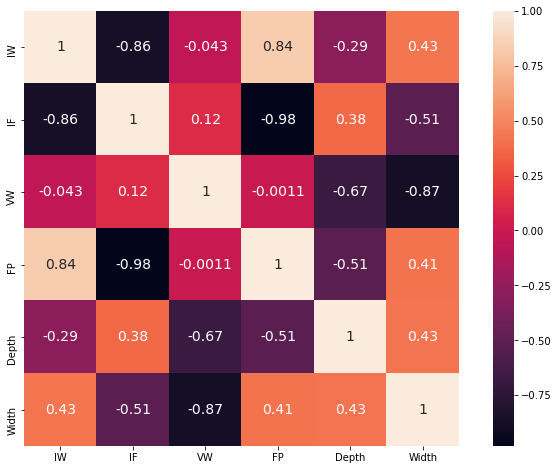

In [200]:
sns.heatmap(data.corr(), annot=True, square=True, cmap='rocket', annot_kws={'size': 14})

Видно что пара признаков (IF и IW), (IF и FP) имеют сильную обратную корреляцию, а IW и FP сильную положительную корреляцию
* Величина сварочного тока (IW);
* Ток фокусировки электронного пучка (IF);
* Скорость сварки (VW);
* Расстояние от поверхности образцов до электронно-оптической системы (FP).

Посмотрим на распеделение цеелвых переменных

Text(0.5, 1.0, 'Распределение целевой переменной Depth')

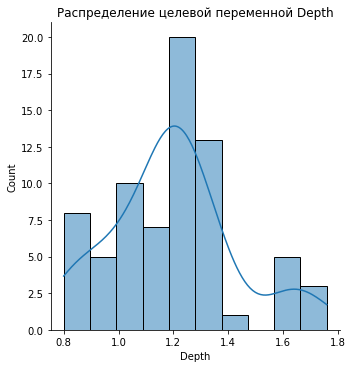

In [206]:
sns.displot(data.Depth, kde=True)
plt.title('Распределение целевой переменной Depth')

Text(0.5, 1.0, 'Распределение целевой переменной Width')

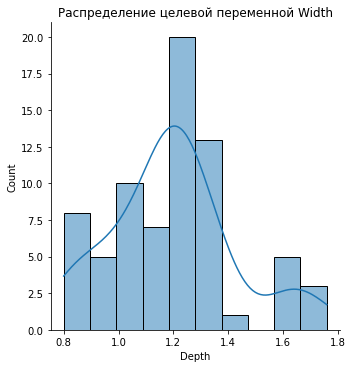

In [209]:
sns.displot(data.Width, kde=True)
plt.title('Распределение целевой переменной Width')

Распределение target не похоже на нормальное, прологарифмируем его

Text(0.5, 1.0, 'Распределение логарифма целевой переменной Width')

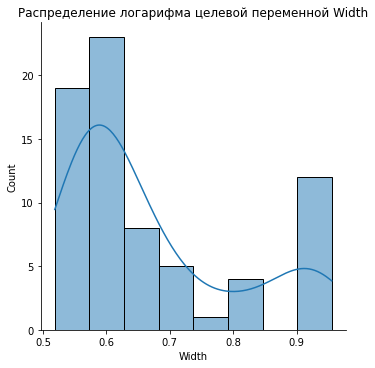

In [386]:
sns.displot(np.log(data.Width), kde=True)
plt.title('Распределение логарифма целевой переменной Width')

In [207]:
import numpy as np

## Моделирование

In [384]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.neighbors import KNeighborsRegressor

import pickle

In [318]:
TEST_SIZE = .2
RANDOM_STATE = 17

In [387]:
scaler = StandardScaler()

X, y = data.drop(['Depth', 'Width'], axis=1), data['Depth']

y_Width = data['Width']

y_log_Width = np.log(y_Width)
y_log = np.log(y)

X_train, X_test, y_train, y_test, y_train_Width, y_test_Width = train_test_split(X, y_log, y_log_Width, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [337]:
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


def exp(y: np.ndarray) -> np.ndarray:
    """
    Потенционирование (обратное логарифмирование) 
    """
    return np.exp(y) - 1

## Baseline

In [351]:
models = [LinearRegression(), RandomForestRegressor(), KNeighborsRegressor()]
scores = dict()

for m in models:
    m.fit(X_train_norm, y_train)
    y_pred = m.predict(X_test_norm)

    print(f'model: {str(m)}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred))), 3)}')
    print(f'MAE: {round(mean_absolute_error(np.exp(y_test), np.exp(y_pred)), 3)}')
    print('-'*30, '\n')

model: LinearRegression()
RMSE: 0.085
MAE: 0.059
------------------------------ 

model: RandomForestRegressor()
RMSE: 0.057
MAE: 0.043
------------------------------ 

model: KNeighborsRegressor()
RMSE: 0.068
MAE: 0.05
------------------------------ 



In [392]:
for m in models:
    m.fit(X_train_norm, y_train_Width)
    y2_pred = m.predict(X_test_norm)

    print(f'model: {str(m)}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(exp(y_test_Width), exp(y2_pred))), 3)}')
    print(f'MAE: {round(mean_absolute_error(np.exp(y_test_Width), np.exp(y2_pred)), 3)}')
    print('-'*30, '\n')

model: LassoCV()
RMSE: 0.07
MAE: 0.058
------------------------------ 

model: RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
RMSE: 0.069
MAE: 0.056
------------------------------ 



In [352]:
from sklearn.linear_model import LassoCV, RidgeCV

In [353]:
lasso_cv = LassoCV(random_state=RANDOM_STATE)
ridge_cv = RidgeCV()

In [357]:
models = [LassoCV(), RidgeCV()]
scores = dict()

for m in models:
    m.fit(X_train_norm, y_train)
    y1_pred = m.predict(X_test_norm)

    print(f'model: {str(m)}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(exp(y_test), exp(y1_pred))), 3)}')
    print(f'MAE: {round(mean_absolute_error(exp(y_test), exp(y1_pred)), 3)}')
    print('-'*30, '\n')

model: LassoCV()
RMSE: 0.084
MAE: 0.058
------------------------------ 

model: RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
RMSE: 0.08
MAE: 0.056
------------------------------ 



## Подбор оптимальных параметров, моделирование + отбор важных признаков:

* Для поиска оптимальных параметров модели. GridSearch: работает дольше, перебирает все варианты

* Используем также кросс-валидацию, чтобы избежать переобучения в том числе

In [395]:
parameters_grid_rf = {
            "n_estimators"      : range(10, 110, 10),
            "min_samples_split" : range(2, 10, 2),
            "bootstrap": [True, False],
}



In [396]:
%%time

model = RandomForestRegressor()
cv = KFold(n_splits=3, shuffle=True)

grid_cv = GridSearchCV(model,
                       parameters_grid_rf,
                       scoring='neg_mean_absolute_error',
                       cv=cv,
                       verbose=1)
grid_cv_Rf.fit(X_train_norm, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Wall time: 8.56 s


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 110, 10)},
             scoring='neg_mean_absolute_error', verbose=1)

In [400]:
pickle.dump(grid_cv, open('Random_Forest_for_Depth.pkl', 'wb'))

In [397]:
grid_cv.best_params_

{'bootstrap': True, 'min_samples_split': 2, 'n_estimators': 20}

In [398]:
y_pred_grid_forest = grid_cv_Rf.predict(X_test_norm)

In [399]:
print(f'RMSE: {round(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_grid_forest))), 3)}')
print(f'MAE: {round(mean_absolute_error(np.exp(y_test), np.exp(y_pred_grid_forest)), 3)}')

RMSE: 0.055
MAE: 0.043


* Для y_test_Width

In [401]:
grid_cv_Rf = GridSearchCV(model,
                       parameters_grid_rf,
                       scoring='neg_mean_absolute_error',
                       cv=cv,
                       verbose=1)
grid_cv_Rf.fit(X_train_norm, y_train_Width)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 110, 10)},
             scoring='neg_mean_absolute_error', verbose=1)

In [404]:
y_pred_grid_forest2 = grid_cv_Rf.predict(X_test_norm)
print(f'RMSE: {round(np.sqrt(mean_squared_error(np.exp(y_test_Width), np.exp(y_pred_grid_forest2))), 3)}')
print(f'MAE: {round(mean_absolute_error(np.exp(y_test_Width), np.exp(y_pred_grid_forest2)), 3)}')

RMSE: 0.058
MAE: 0.049


In [405]:
pickle.dump(grid_cv_Rf, open('Random_Forest_for_Width.pkl', 'wb'))

## Проверяес градиентный бустинг

In [374]:
from sklearn.ensemble import GradientBoostingRegressor

In [380]:
gbtree = GradientBoostingRegressor(n_estimators=100, subsample=0.5, random_state=42)
gbtree.fit(X_train_norm, y_train)
gb_predict = gbtree.predict(X_test_norm)

In [383]:
print(f'RMSE: {round(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(gb_predict))), 3)}')
print(f'MAE: {round(mean_absolute_error(np.exp(y_test), np.exp(gb_predict)), 3)}')

RMSE: 0.064
MAE: 0.047


In [375]:
parameters_grid = {
            "n_estimators"      : range(50, 110, 10),
            "min_samples_split" : range(2, 6, 1),
            "min_samples_leaf" : range(1, 6, 1),
            "max_depth": range(2, 6, 1),
            "max_features":  range(1, 6, 1),
            "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}
#             "loss": ['squared_error', 'absolute_error'],


In [376]:
model = GradientBoostingRegressor()
cv = KFold(n_splits=4, shuffle=True)

DR_grid_cv = GridSearchCV(model,
                       parameters_grid,
                       scoring='neg_mean_absolute_error',
                       cv=cv,
                       verbose=1)
DR_grid_cv.fit(X_train_norm, y_train)

Fitting 4 folds for each of 14400 candidates, totalling 57600 fits


GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': range(2, 6), 'max_features': range(1, 6),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(2, 6),
                         'n_estimators': range(50, 110, 10),
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             scoring='neg_mean_absolute_error', verbose=1)

In [377]:
DR_grid_cv_predict = DR_grid_cv.predict(X_test_norm)

In [379]:
print(f'RMSE: {round(np.sqrt(mean_squared_error(exp(y_test), exp(DR_grid_cv_predict))), 3)}')
print(f'MAE: {round(mean_absolute_error(exp(y_test), exp(DR_grid_cv_predict)), 3)}')

RMSE: 0.06
MAE: 0.044


In [ ]:
DR_grid_cv.best_params_

In [145]:
X1_train_norm

array([[-0.05842062, -0.18493168,  0.58671882,  0.23817559],
       [-0.05842062,  1.10959008,  0.58671882, -0.9743547 ],
       [ 0.75946811, -0.70274039, -1.46679705,  0.23817559],
       [-0.87630936, -0.44383603, -1.46679705,  0.23817559],
       [-0.05842062,  1.10959008,  0.58671882, -0.9743547 ],
       [ 0.75946811, -0.18493168,  1.33345187,  0.23817559],
       [ 2.39524558, -2.51507085, -0.16001422,  2.96636876],
       [ 0.75946811, -0.70274039, -1.46679705,  0.23817559],
       [-0.87630936,  1.10959008,  0.2133523 , -0.9743547 ],
       [-0.05842062,  1.10959008,  0.58671882, -0.9743547 ],
       [-1.69419809,  1.10959008,  0.2133523 , -0.9743547 ],
       [ 0.75946811, -0.18493168,  1.33345187,  0.23817559],
       [-0.87630936, -0.44383603, -1.46679705,  0.23817559],
       [-0.87630936, -0.18493168,  0.58671882,  0.23817559]])

## Сохраняем модель

Лучше всего по RLMSE себя показал случайный лес, сохраняем его для использования в приложении